<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

Se utilizará como dataset los tweets sobre ChatGPT que van de Enero a Marzo de 2023 para generar los embeddings. Los vectores tendrán la forma en función de como los usuarios hayan utilizado las palabras en sus tweets sobre ChatGPT.

Fuente: https://www.kaggle.com/datasets/khalidryder777/500k-chatgpt-tweets-jan-mar-2023

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [5]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data.to(device)).cpu()

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data.to(device)).cpu()
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [6]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('tweets-jan-mar.csv', nrows=4000)

df = df['content']
df = df.fillna('')
df.head()

0    Free AI marketing and automation tools, strate...
1             @MecoleHardman4 Chat GPT says it’s 15. 😂
2    https://t.co/FjJSprt0te - Chat with any PDF!\n...
3    AI muses: "In the court of life, we must all f...
4    Most people haven't heard of Chat GPT yet.\nFi...
Name: content, dtype: object

In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 4000


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [8]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 2

In [9]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0]
text

'Free AI marketing and automation tools, strategies, and collaboration launching new week https://t.co/Qwti8LfBpb   #ChatGPT'

In [10]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['free',
 'ai',
 'marketing',
 'and',
 'automation',
 'tools',
 'strategies',
 'and',
 'collaboration',
 'launching',
 'new',
 'week',
 'https',
 't',
 'co',
 'qwti8lfbpb',
 'chatgpt']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [11]:
sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].to_frame().iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [12]:
# Demos un vistazo
sentence_tokens[:2]

[['free',
  'ai',
  'marketing',
  'and',
  'automation',
  'tools',
  'strategies',
  'and',
  'collaboration',
  'launching',
  'new',
  'week',
  'https',
  't',
  'co',
  'qwti8lfbpb',
  'chatgpt'],
 ['mecolehardman4', 'chat', 'gpt', 'says', 'it’s', '15', '😂']]

In [13]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [14]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
# seq_input + output
text_sequences

[['free', 'ai'],
 ['ai', 'marketing'],
 ['marketing', 'and'],
 ['and', 'automation'],
 ['automation', 'tools'],
 ['tools', 'strategies'],
 ['strategies', 'and'],
 ['and', 'collaboration'],
 ['collaboration', 'launching'],
 ['launching', 'new'],
 ['new', 'week'],
 ['week', 'https'],
 ['https', 't'],
 ['t', 'co'],
 ['co', 'qwti8lfbpb']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [15]:
tok = Tokenizer()

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [16]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[14, 2],
 [2, 3],
 [3, 1],
 [1, 4],
 [4, 5],
 [5, 6],
 [6, 1],
 [1, 7],
 [7, 8],
 [8, 9],
 [9, 10],
 [10, 11],
 [11, 12],
 [12, 13],
 [13, 15]]

In [17]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

15


In [18]:
# Cantidad de palabras distintas
print(len(tok.word_counts))

15


In [19]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'and': 1, 'ai': 2, 'marketing': 3, 'automation': 4, 'tools': 5, 'strategies': 6, 'collaboration': 7, 'launching': 8, 'new': 9, 'week': 10, 'https': 11, 't': 12, 'co': 13, 'free': 14, 'qwti8lfbpb': 15}


In [20]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'free': 1, 'ai': 2, 'marketing': 2, 'and': 4, 'automation': 2, 'tools': 2, 'strategies': 2, 'collaboration': 2, 'launching': 2, 'new': 2, 'week': 2, 'https': 2, 't': 2, 'co': 2, 'qwti8lfbpb': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [21]:
# Vistazo a las primeras filas
df.loc[:15]

0     Free AI marketing and automation tools, strate...
1              @MecoleHardman4 Chat GPT says it’s 15. 😂
2     https://t.co/FjJSprt0te - Chat with any PDF!\n...
3     AI muses: "In the court of life, we must all f...
4     Most people haven't heard of Chat GPT yet.\nFi...
5     @nytimes No! Chat Gpt has been putting togethe...
6     @ylzkrtt Yes also by chat gpt you can make gen...
7     @robinhanson @razibkhan Most people haven't he...
8     Yours Robotically - by Shaun Usher - Letters o...
9     This is a metaphor for the limited perception ...
10    Anyone familiar with The "cave allegory"? In t...
11    @ThatOuternaut HEY CHAT GPT I DON'T GOT TIME F...
12    #GenerativeAI  such as #ChatGPT could replace ...
13    @rasbt Reading it right now love the fact that...
14    The oracle is a program created by the machine...
15    You know what a good feature be in ChatGPT @Op...
Name: content, dtype: object

In [22]:
# Concatenamos todos los rows en un solo valor
corpus = ' '.join(df.values.astype(str).flatten())
corpus

'Free AI marketing and automation tools, strategies, and collaboration launching new week https://t.co/Qwti8LfBpb   #ChatGPT @MecoleHardman4 Chat GPT says it’s 15. 😂 https://t.co/FjJSprt0te - Chat with any PDF!\nCheck out how this new AI quickly answers questions from your PDFs.\nPerfect for students, researchers, and other curious minds. \n#research #chatpdf #ChatGPT AI muses: "In the court of life, we must all face the judge of destiny and the jury of our actions. ⚖️🔮 #OutOfContextAI #AILifeLessons #ChatGPT Most people haven\'t heard of Chat GPT yet.\nFirst, elite factions will decide which way to go on AI safety. Next they will push their agenda(s) on the public with misleading and oversimplified media presentations. Finally, the brainless Red and Blue camps will screech their lines @nytimes No! Chat Gpt has been putting together amazing recipes 😫😫😫 @ylzkrtt Yes also by chat gpt you can make generative art more easy but needs code KNOWLEDGE. I did post resently some article about th

In [23]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['free',
 'ai',
 'marketing',
 'and',
 'automation',
 'tools',
 'strategies',
 'and',
 'collaboration',
 'launching',
 'new',
 'week',
 'https',
 't',
 'co',
 'qwti8lfbpb',
 'chatgpt',
 'mecolehardman4',
 'chat',
 'gpt']

In [24]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 112629


In [25]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [26]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['free', 'ai'],
 ['ai', 'marketing'],
 ['marketing', 'and'],
 ['and', 'automation'],
 ['automation', 'tools'],
 ['tools', 'strategies'],
 ['strategies', 'and'],
 ['and', 'collaboration'],
 ['collaboration', 'launching'],
 ['launching', 'new'],
 ['new', 'week'],
 ['week', 'https'],
 ['https', 't'],
 ['t', 'co'],
 ['co', 'qwti8lfbpb'],
 ['qwti8lfbpb', 'chatgpt'],
 ['chatgpt', 'mecolehardman4'],
 ['mecolehardman4', 'chat'],
 ['chat', 'gpt'],
 ['gpt', 'says']]

In [27]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[210, 9],
 [9, 204],
 [204, 7],
 [7, 542],
 [542, 116],
 [116, 2928],
 [2928, 7],
 [7, 2010],
 [2010, 2399],
 [2399, 61],
 [61, 265],
 [265, 5],
 [5, 4],
 [4, 3],
 [3, 5853],
 [5853, 1],
 [1, 5854],
 [5854, 12],
 [12, 10],
 [10, 276]]

In [28]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 112627


### 3 - Input y target

In [29]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(112627, 1)
(112627,)


In [30]:
# Palabras del vocabulario
tok.index_word

{1: 'chatgpt',
 2: 'the',
 3: 'co',
 4: 't',
 5: 'https',
 6: 'to',
 7: 'and',
 8: 'a',
 9: 'ai',
 10: 'gpt',
 11: 'of',
 12: 'chat',
 13: 'is',
 14: 'for',
 15: 'it',
 16: 'in',
 17: 'i',
 18: 'with',
 19: 'you',
 20: 'on',
 21: 'that',
 22: 'this',
 23: 'are',
 24: 'be',
 25: 'can',
 26: 'your',
 27: 'openai',
 28: 'how',
 29: 'about',
 30: 'my',
 31: 'will',
 32: 'as',
 33: 'we',
 34: 'have',
 35: 'an',
 36: 'more',
 37: 'what',
 38: 'by',
 39: 'but',
 40: '4',
 41: 'not',
 42: 'like',
 43: 'from',
 44: 'use',
 45: 'just',
 46: 'out',
 47: 'at',
 48: 'all',
 49: 'or',
 50: 'me',
 51: 'do',
 52: 'so',
 53: 'gpt4',
 54: 'now',
 55: 'if',
 56: 'using',
 57: 'amp',
 58: 'has',
 59: 'our',
 60: 'artificialintelligence',
 61: 'new',
 62: 'was',
 63: 'technology',
 64: "it's",
 65: 'up',
 66: 'its',
 67: 'they',
 68: '3',
 69: 'get',
 70: 'here',
 71: 'asked',
 72: 'than',
 73: 'write',
 74: 'could',
 75: 'make',
 76: 'when',
 77: 'some',
 78: 'know',
 79: '5',
 80: 'one',
 81: 'their',
 8

In [31]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

16749

In [32]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [33]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [34]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        y_tensor = torch.from_numpy(y).long()
        self.y = F.one_hot(y_tensor, num_classes=vocab_size).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 1
Output dim 16749


In [43]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 90102
Tamaño del conjunto de validacion: 22525


### 4 - Entrenar el modelo

In [44]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim, device):
        super().__init__()
        self.lstm_size = 64
        self.num_layers = 1
        self.device = device
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=16, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=16, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2, bidirectional=True) # Bidirectional LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size*2, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers*2, batch_size, self.lstm_size).to(self.device),
                torch.zeros(self.num_layers*2, batch_size, self.lstm_size).to(self.device))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, else CPU

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim, device=device)
if cuda: model1.cuda()

model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

summary(model1, input_data=data_set[0][0].unsqueeze(0).to(device))

c:\Users\jonat\anaconda3\envs\nlp\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 16749]                --
├─Embedding: 1-1                         [1, 1, 16]                268,000
├─LSTM: 1-2                              [1, 1, 128]               41,984
├─Linear: 1-3                            [1, 32]                   4,128
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 16749]                552,717
├─Softmax: 1-6                           [1, 16749]                --
Total params: 866,829
Trainable params: 866,829
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 3.47
Estimated Total Size (MB): 3.60

In [45]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=20
                )

Epoch: 1/20 - Train loss 9.644 - Train accuracy 0.085 - Valid Loss 9.633 - Valid accuracy 0.093
Epoch: 2/20 - Train loss 9.628 - Train accuracy 0.099 - Valid Loss 9.624 - Valid accuracy 0.102
Epoch: 3/20 - Train loss 9.621 - Train accuracy 0.106 - Valid Loss 9.619 - Valid accuracy 0.108
Epoch: 4/20 - Train loss 9.615 - Train accuracy 0.112 - Valid Loss 9.618 - Valid accuracy 0.109
Epoch: 5/20 - Train loss 9.612 - Train accuracy 0.115 - Valid Loss 9.616 - Valid accuracy 0.110
Epoch: 6/20 - Train loss 9.610 - Train accuracy 0.116 - Valid Loss 9.616 - Valid accuracy 0.111
Epoch: 7/20 - Train loss 9.608 - Train accuracy 0.118 - Valid Loss 9.615 - Valid accuracy 0.111
Epoch: 8/20 - Train loss 9.607 - Train accuracy 0.119 - Valid Loss 9.615 - Valid accuracy 0.111
Epoch: 9/20 - Train loss 9.605 - Train accuracy 0.121 - Valid Loss 9.614 - Valid accuracy 0.112
Epoch: 10/20 - Train loss 9.602 - Train accuracy 0.124 - Valid Loss 9.613 - Valid accuracy 0.113
Epoch: 11/20 - Train loss 9.601 - Train

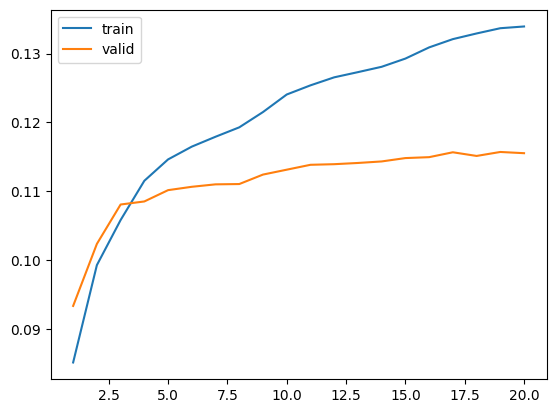

In [46]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

__Es importante__ destacar que en este ejemplo estamos entrenando nuestro propios Embeddings y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

### 5 - Predicción de próxima palabra

In [47]:
# pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [48]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [49]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Transformo a tensor
    tensor = torch.from_numpy(encoded.astype(np.int32))

    device = next(model1.parameters()).device  # get the device of the model
    tensor = tensor.to(device)  # move the tensor to the same device

    # Predicción softmax
    y_hat = model1(tensor).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

c:\Users\jonat\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jonat\AppData\Local\Temp\ipykernel_5988\2974817273.py:30: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [50]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32))

        device = next(model1.parameters()).device  # get the device of the model
        tensor = tensor.to(device)  # move the tensor to the same device

        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [56]:
input_text='automation and'

generate_seq(model1, tok, input_text, max_length=3, n_words=5)

'automation and chatgpt to chatgpt to chatgpt'

### 7 - Conclusiones
El modelo entrenado tuvo una mala performance durante el entrenamiento además de overfitting y estancamiento en la mejora de la precisión sobre el conjunto de validación a lo largo de las épocas.

Esto se debe a que el dataset es muy pequeño para el objetivo que se quiere alcanzar además de que no se cuenta con el hardware para lograr el entrenamiento en el tiempo que se dispone.

Se observa que para muchos términos se los relaciona con "chatgpt" como próxima palabra porque es el término que siempre está presente en todos los tweets.

Para mejorar el desempeño se pueden realizar las siguientes acciones:

- Utilizar embeddings ya pre-entrenados porque es muy costoso hacerlo por cuenta propia.
- Incrementar la cantidad de épocas
- Hacer un preprocessing exhaustivo para eliminar palabras que no aportan información como hashtags, menciones, etc.

Se destaca de la resolución de este desafío la utilización de un dataset con un vocabulario más amplio y por ende con muchos más parámetros en la capa de embeddings para entrenar a comparación del notebook modelo de la clase, así como también la incorporación de LSTM bidireccional para mejorar la performance del modelo.